# Hard-Soft - Multivariate Curve Resolutions - Alternating Least Squares

In [82]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library

times = np.linspace(0, 2, num=500)  # linear space of times from 0 to 499 in arbitrary units
wavelengths = np.arange(300, 600)  # linear space of wavelengths from 300 to 599 in arbitrary units

t, w = times.shape[0], wavelengths.shape[0]  # dimensions of times and wavelenths
t, w


(500, 300)

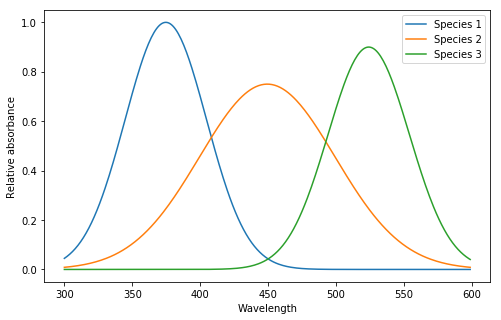

In [83]:
# n = 3  # we will have 3 absorbing species

# C = np.zeros((t, n))  # define concentration matrix with dimensions t x n
# E = np.zeros((n, w))  # define epsilon matrix with dimensions n x w

def plot_ST(wls, ST):
    # plot created spectra
    plt.rcParams['figure.figsize'] = [8, 5]
    for i in range(ST.shape[0]):
        plt.plot(wavelengths, ST[i], label='Species {}'.format(i+1))
    plt.xlabel('Wavelength')
    plt.ylabel('Relative absorbance')
    plt.legend()
    plt.show()

def create_ST(wls, n=3, pos=(0.25, 0.5, 0.75), sigmas=(30, 50, 30), magnitudes=(1, 0.75, 0.9)):
    def gauss(x, mu, sigma):
        return np.exp(- (x - mu) * (x - mu) / (2 * sigma * sigma))
    ST = np.zeros((n, wls.shape[0]))
    for i in range(n):
        ST[i] = magnitudes[i] * gauss(wls, wls[0] + pos[i]*(wls[-1] - wls[0]), sigmas[i])
    return ST

ST = create_ST(wavelengths)
plot_ST(wavelengths, ST)

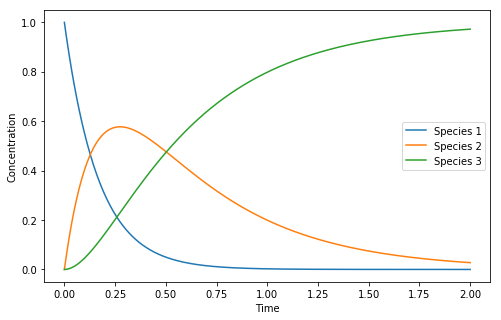

In [84]:
# c0, k1, k2 = 1, 0.015, 0.008  # for simplification, we assume that c0 = 1

def create_C(times, n=3, k1=6, k2=2):
    C = np.zeros((times.shape[0], n))
    
    C[:, 0] =  np.exp(-k1 * times)
    C[:, 1] = k1 / (k2 - k1) * (np.exp(-k1 * times) - np.exp(-k2 * times))
    C[:, 2] = 1 - C[:, 0] - C[:, 1]
    
    return C

def plot_C(times, C):
    plt.rcParams['figure.figsize'] = [8, 5]
    for i in range(C.shape[1]):
        plt.plot(times, C[:, i], label='Species {}'.format(i+1))
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()

C = create_C(times, n=3)
plot_C(times, C)

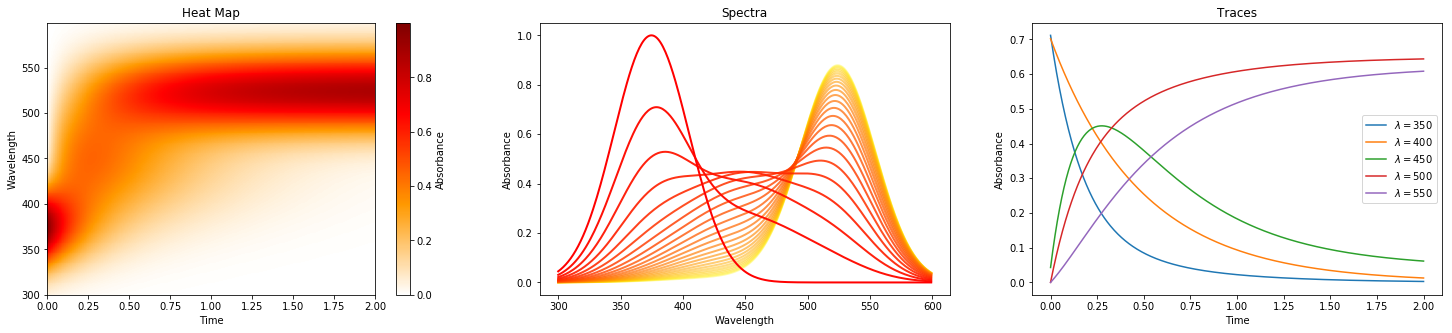

In [91]:
x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
z = C @ ST

from matplotlib.colors import LinearSegmentedColormap

# define custom color map, first column is the position on the color map, second column is the value of that color
# at the start of the region and 3rd column is value of that color at the end of the region (from 0 - 1)
# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
cdict = {'red':   ((0.0, 1.0, 1.0),
#                    (1/3, 1.0, 1.0),
                   (2/3, 1.0, 1.0),
                   (1.0, 0.5, 0.5)),

         'green': ((0.0, 1, 1),
                   (1/3, 0.6, 0.6),
                   (2/3, 0, 0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (1/3, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
        }

custom_cmap = LinearSegmentedColormap('custom', cdict)

# plot heat map, spectra and traces
def plot_A(A, times, wavelengths):
    plt.rcParams['figure.figsize'] = [25, 5]
    plt.subplot(1, 3, 1)
    x, y = np.meshgrid(times, wavelengths)  # needed for pcolormesh to correctly scale the image
    plt.pcolormesh(x, y, A.T, cmap=custom_cmap)
    plt.colorbar(label='Absorbance')
    plt.title("Heat Map")
    plt.ylabel('Wavelength')
    plt.xlabel('Time')
    
    plt.subplot(1, 3, 2)
    for i in reversed(range(0, t, 20)):
        plt.plot(wavelengths, A[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=2)
    plt.title("Spectra")
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    # plt.legend()
    
    plt.subplot(1, 3, 3)
    for i in range(50, w, 50):
        plt.plot(times, A[:, i], label='$\lambda = {}$'.format(wavelengths[i]))
    plt.title("Traces")
    plt.xlabel('Time')
    plt.ylabel('Absorbance')
    plt.legend()
    
    plt.show()

plot_A(z, times, wavelengths)


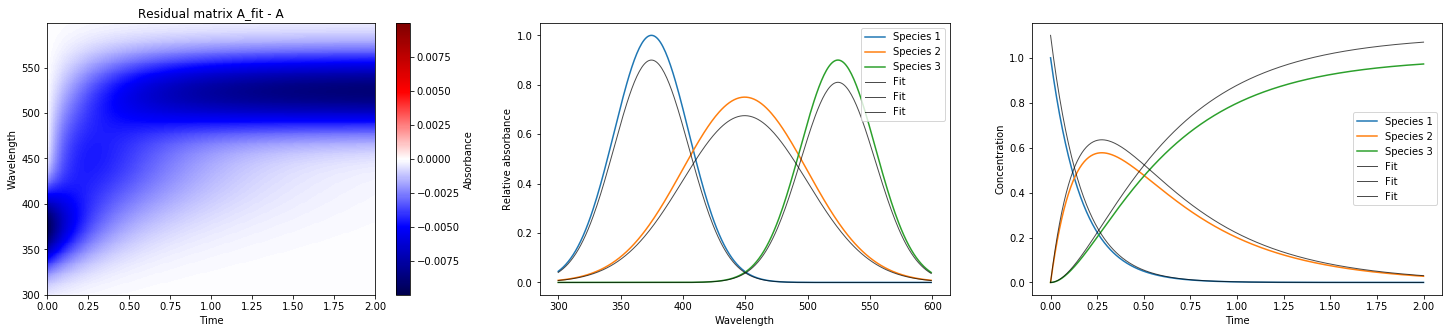

In [92]:
def plot_C_ST_resA(times, wavelengths, C, ST, C_fit, ST_fit):
    plt.rcParams['figure.figsize'] = [25, 5]
    n = ST.shape[0]
    plt.subplot(1, 3, 1)
    x, y = np.meshgrid(times, wavelengths)  # needed for pcolormesh to correctly scale the image
    resA = C_fit @ ST_fit - C @ ST
    extrem = np.max(resA) if np.abs(np.max(resA)) > 1e-10 else np.min(resA)
    plt.pcolormesh(x, y, resA.T, cmap='seismic', vmin=-np.abs(extrem), vmax=np.abs(extrem))
    plt.colorbar(label='Absorbance')
    plt.title("Residual matrix A_fit - A")
    plt.ylabel('Wavelength')
    plt.xlabel('Time')
    
    plt.subplot(1, 3, 2)
    for i in range(n):
        plt.plot(wavelengths, ST[i], label=f'Species {i+1}')
    for i in range(n):
        plt.plot(wavelengths, ST_fit[i], label='Fit', color=(0, 0, 0, 0.7), lw=1)
    plt.xlabel('Wavelength')
    plt.ylabel('Relative absorbance')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    for i in range(n):
        plt.plot(times, C[:, i], label=f'Species {i+1}')
    for i in range(n):
        plt.plot(times, C_fit[:, i], label='Fit', color=(0, 0, 0, 0.7), lw=1)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()

plot_C_ST_resA(times, wavelengths, C, ST, C*1.1, ST*0.9)



$$\mathbf A  = \mathbf C \mathbf{S^T} $$

Best fit of spectral matrix $\mathbf{S^T}$: 

$$\mathbf{S^T} = \mathbf {C^+A}$$

Best fit of concentration matrix $\mathbf{C}$: 

$$\mathbf{C} = \mathbf {AS^{+T}}$$

In [1]:
from scipy.linalg import lstsq
from scipy.optimize import nnls
from copy import deepcopy

# fit of ST: lstsq(C, A)[0]
# fit of C: lstsq(ST.T, A.T)[0].T
    
A = z

# ST_est = deepcopy(ST)
# ST_est[1:, :] = np.random.rand(2, w) * 0.1
# ST_est = np.random.rand(3, w) * 0.1

# C_est = np.zeros((t, n))

# for num in range(n):
#     C_est[:, num] = _nnls(ST_est.T, A.T[:, num])
C_est = lstsq(ST_est.T, A.T)[0].T
C_est = C_est * (C_est > 0)  # non-negativity constrain

plot_C_ST_resA(times, wavelengths, C, ST, C_est, ST_est)


NameError: name 'z' is not defined

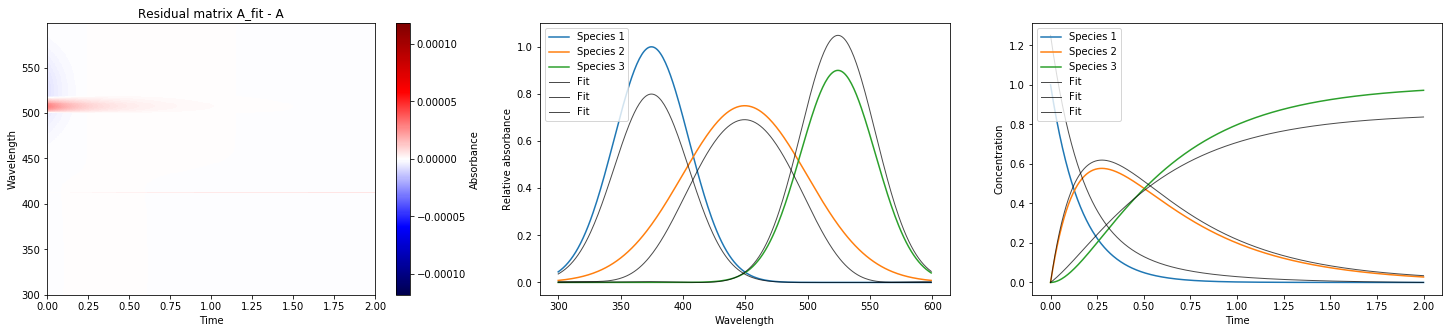

In [190]:
ST_est = lstsq(C_est, A)[0]
ST_est = ST_est * (ST_est > 0)  # non-mnegativity constrain

plot_C_ST_resA(times, wavelengths, C, ST, C_est, ST_est)

In [196]:
it = 500
# MCR-ALS
for i in range(it):
    C_est = lstsq(ST_est.T, A.T)[0].T
    C_est = C_est * (C_est > 0)  # non-negativity constrain
    
    ST_est = lstsq(C_est, A)[0]
    ST_est = ST_est * (ST_est > 0)  # non-mnegativity constrain


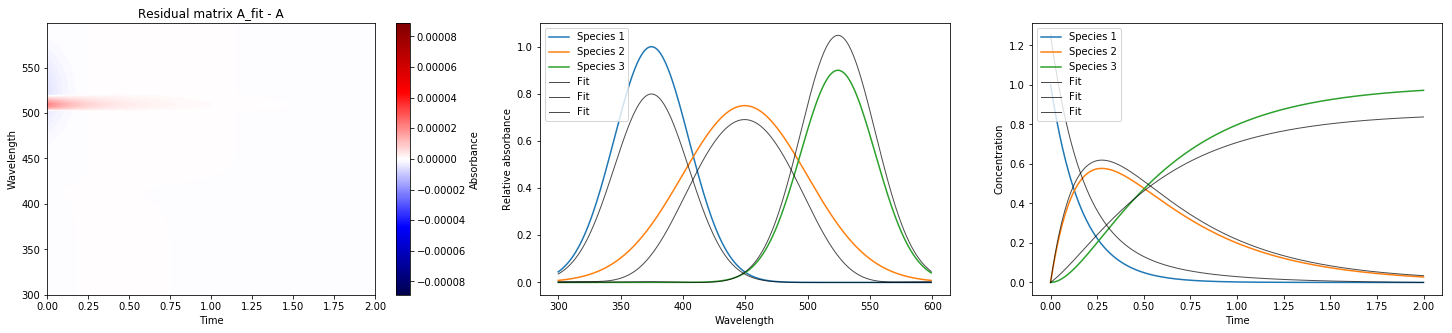

In [197]:
plot_C_ST_resA(times, wavelengths, C, ST, C_est, ST_est)

In [230]:
from lmfit import Parameters, report_fit, Minimizer

params = Parameters()
# params.add('c0', value=1, min=0, max=np.inf, vary=False)
params.add('k1', value=1, min=0, max=np.inf, vary=True)
# params.add('k2', value=0.5, min=0, max=np.inf, vary=True)

def calc_C(params, C):
    k1 = params['k1'].value
    # calculate concetration matrix according to our model for parameters k1
    C[:, 0] = np.exp(-k1 * times)

def residuals(params, A, C_opt, ST):
    calc_C(params, C_opt)
#     ST = lstsq(C_opt, A)[0]
    A_opt = C_opt @ ST
    R = A_opt - A
    return R

def target_fit(A, C_est, ST, params):
    _C_opt = deepcopy(C_est)
    m = Minimizer(residuals, params, fcn_args=(A, _C_opt, ST))
    result = m.minimize(method='leastsq')
#     report_fit(result)
    return result.params, _C_opt

                  
params_fit, C_opt = target_fit(A, C_est, ST_est, params)

1
5.998942680618458


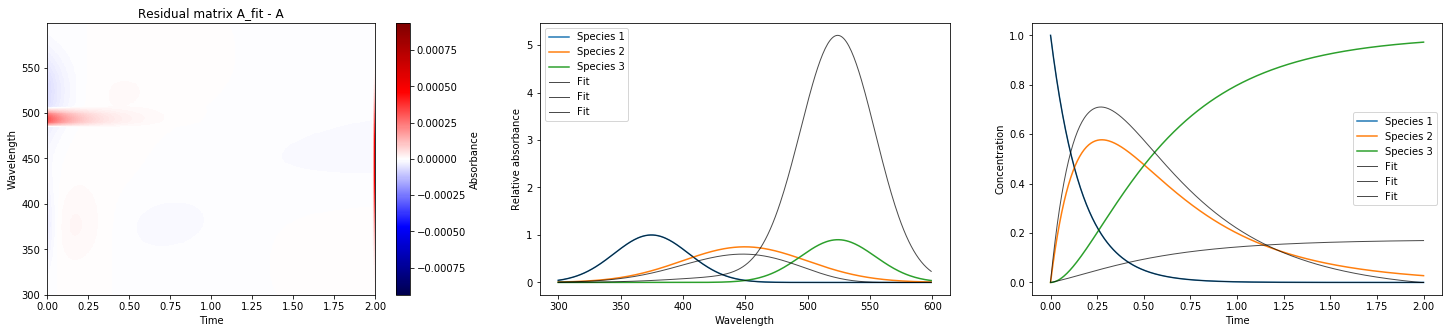

In [263]:
# plot_C_ST_resA(times, wavelengths, C, ST, C_opt, ST_est)

def HS_MCR(A, params, it=5, tar_n=1):
    
    ST_est = np.random.rand(3, w) * 0.1
    
    for i in range(it):
        C_est = lstsq(ST_est.T, A.T)[0].T
        C_est = C_est * (C_est > 0)  # non-negativity constrain
        
#         perform hard fitting
        if i % tar_n == 0:
            params_fit, C_est = target_fit(A, C_est, ST_est, params)

        ST_est = lstsq(C_est, A)[0]
        ST_est = ST_est * (ST_est > 0)  # non-mnegativity constrain
        
    print(params_fit['k1'].value)
    return C_est, ST_est

params_fit['k1'].value = 1
print(params_fit['k1'].value)
C_opt, ST_opt = HS_MCR(A, params, it=100, tar_n=1)
plot_C_ST_resA(times, wavelengths, C, ST, C_opt, ST_opt)

# C_test = deepcopy(C_opt)
# C_test[:, 0] = np.exp(-6 * times)
# plot_C_ST_resA(times, wavelengths, C, ST, C_test, ST_est)